# Dependencies loading 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

# Data loading

In [2]:
base_url = "https://raw.githubusercontent.com/Niyetali/FIFA-Rating-Prediction/main/output"

# Importing datasets
X_train = pd.read_csv(f"{base_url}/X_train_fe.csv", sep=",", encoding="utf-8", on_bad_lines='skip', engine="python")
X_test = pd.read_csv(f"{base_url}/X_test_fe.csv", sep=",", encoding="utf-8", on_bad_lines='skip', engine="python")
y_train = pd.read_csv(f"{base_url}/y_train.csv", sep=",", encoding="utf-8", on_bad_lines='skip', engine="python")
y_test = pd.read_csv(f"{base_url}/y_test.csv", sep=",", encoding="utf-8", on_bad_lines='skip', engine="python")

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(14100, 42) (3525, 42)
(14100, 1) (3525, 1)


In [3]:
print(X_train.dtypes)

Name                         object
Age                           int64
Nationality                 float64
Potential                     int64
Club                        float64
International Reputation    float64
Weak Foot                   float64
Skill Moves                 float64
Body_Type                     int64
Attacking_Work_Rate           int64
Defensive_Work_Rate           int64
CB                            int64
CDM                           int64
CF                            int64
CM                            int64
GK                            int64
LAM                           int64
LB                            int64
LCB                           int64
LCM                           int64
LDM                           int64
LF                            int64
LM                            int64
LS                            int64
LW                            int64
LWB                           int64
RAM                           int64
RB                          

# XGBoost model

Let's drop the `Name` column:

In [4]:
X_train = X_train.drop(columns=["Name"])
X_test = X_test.drop(columns=["Name"])

### Simple base model

In [5]:
# Initializing simple AdaBoost regressor
xgb_model = XGBRegressor(random_state=42)

# Training AdaBoost regressor 
xgb_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = xgb_model.predict(X_test)

### Model Evaluation

In [6]:

# Mean Squarred Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R2 score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Adjusted R2 
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print(f"Adjusted R² Score: {r2}")

# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Mean Absolute Percentage Error
y_test = y_test.squeeze()  # Converting DataFrame to Series
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")

# Symmetric MAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
print(f"Symmetric Mean Absolute Percentage Error: {smape}")

Mean Squared Error: 0.8068174762403921
R² Score: 0.9873731136322021
Adjusted R² Score: 0.9873731136322021
Root Mean Squared Error: 0.8982301911205124
Mean Absolute Error: 0.5248778874823388
Mean Absolute Percentage Error: 0.8640468176294991
Symmetric Mean Absolute Percentage Error: 0.8650591835336267


The above metrics are derived from the XGBoost Regressor, implemented without any hyperparameter tuning to establish a baseline for its performance. The results are impressive and indicate robust predictive capabilities:

- **R² Score**: The model accounts for 98.74% of the variance in the target variable, highlighting its strong explanatory power.
- **Mean Squared Error (MSE)**: The average squared difference between actual and predicted values is 0.806, reflecting high accuracy in predictions.
- **Root Mean Squared Error (RMSE)**: The typical error, measured in the same units as the target variable, is 0.898, indicating low prediction errors.
- **Mean Absolute Error (MAE**): The average absolute prediction error is approximately 0.525, showcasing the model’s precision.
- **Mean Absolute Percentage Error (MAPE)**: Predictions deviate by only 0.86% from actual values on average, which is highly satisfactory.
- **Symmetric Mean Absolute Percentage Error (SMAPE)**: Similar to MAPE, the SMAPE value of 0.865% confirms the minimal deviation while accounting for the relative scale of predictions and actual values.

The model demonstrates exceptional performance, as indicated by its high R² score and low error metrics. Furthermore, the small gap between MAE and RMSE suggests that the model is not significantly affected by outliers, reinforcing its reliability as a baseline model.

### Scatter Plot 

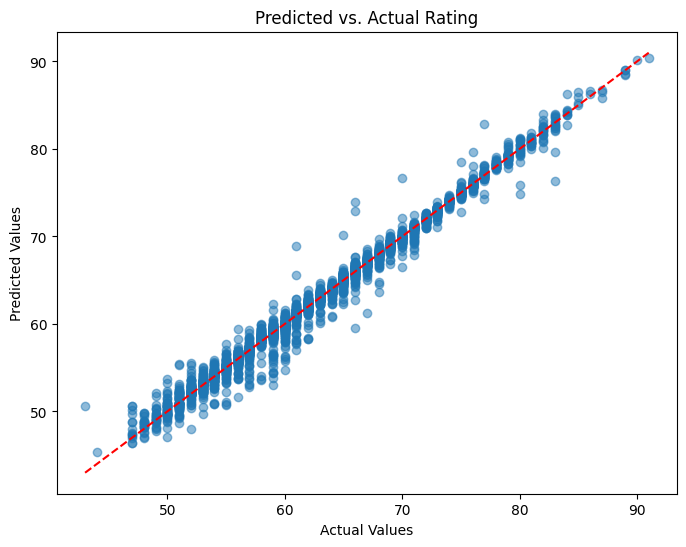

In [7]:
# actual vs. predicted values of "Overall"
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Rating')
plt.show()

The alignment of predictions is consistent across the range of actual values, demonstrating the model's capability to generalize well without significant bias toward specific ranges. Some divergence is visible at higher actual ratings, where a few predicted values deviate more noticeably. This could indicate room for improvement in those specific regions, which will perhaps be improved with additional fine-tuning

### Residual Plot

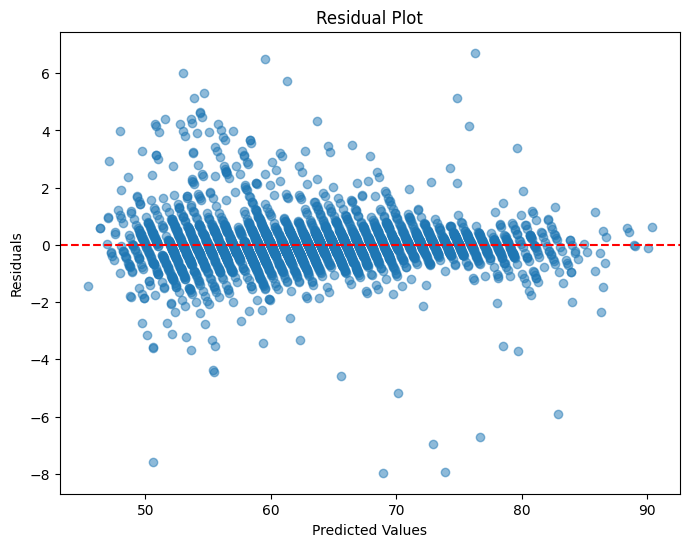

In [8]:
# Converting test set to a 1D Series
#y_test = y_test.squeeze()  # Converts a single-column DataFrame to a Series

# residuals
residuals = y_test - y_pred

# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The residual plot indicates that the model performs well overall, as the residuals are generally close to zero with no obvious trends or patterns. Nontheless, there is a slight funnel shape visible in the plot, where the residual variance decreases for higher predicted values, which suggests that the model's errors are slightly heteroscedastic (varying across different prediction ranges)

### Distribution of Residuals 

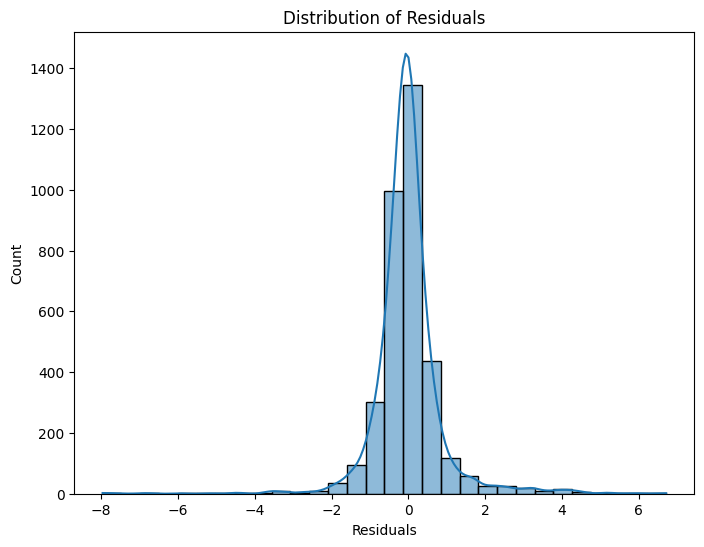

In [9]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

Similarly as in Adaboost, the residuals of our XGBoost model follow near-normal distribution and aligns with the assumption of independence and randomness in errors, which is a good sign for the validity of the model. There are a small number of residuals outside the main distribution range (e.g., beyond -6 or +6). These might be due to outliers in the dataset or limitations in the model's ability to predict certain instances.


### Q-Q Plot for Residuals 

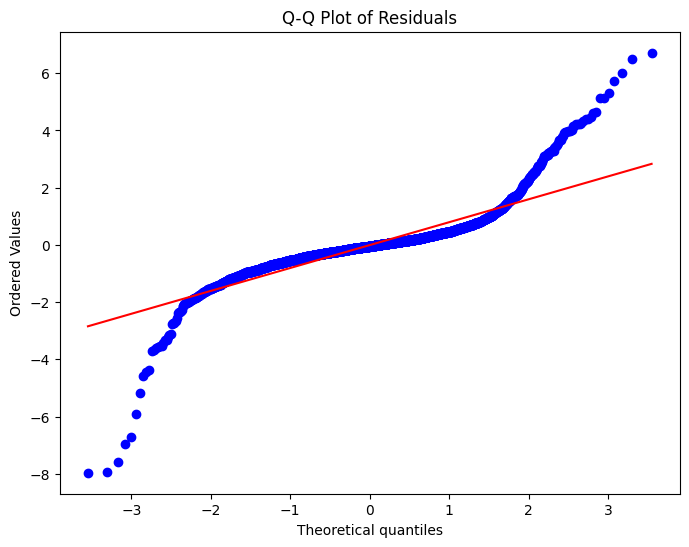

In [10]:
# Q-Q plot for residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

The Q-Q plot shows that the residuals are approximately normal in the central range, with some deviations at the tails. These deviations are not uncommon and are unlikely to significantly impact the overall model performance. However, we will further investigate the extreme cases might help refine the model further

# Hyperparameter Tuning 

In [11]:
# Define the updated parameter grid to search
param_dist = {
    'n_estimators': [50, 100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],   
    'max_depth': [2, 3, 5, 7],                               
    'subsample': [0.2, 0.3, 0.5, 0.7, 0.9],           
    'colsample_bytree': [0.2, 0.3, 0.5, 0.7, 0.9],
    'reef_alpha': [50, 100, 200], #L1 regularization                            
    'reg_lambda': [50, 100, 200] # L2 regularization
}

# lets initialize the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)

# performing RandomizedSearchCV with early stopping
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=50, scoring='neg_mean_squared_error', cv=10, random_state=42)

# fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# best hyperparameters & best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_
print("Best Parameters: ", best_params)

# predictions
y_pred = best_model.predict(X_test)

Best Parameters:  {'subsample': 0.9, 'reg_lambda': 50, 'reef_alpha': 200, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.7}


### Learning Curve 

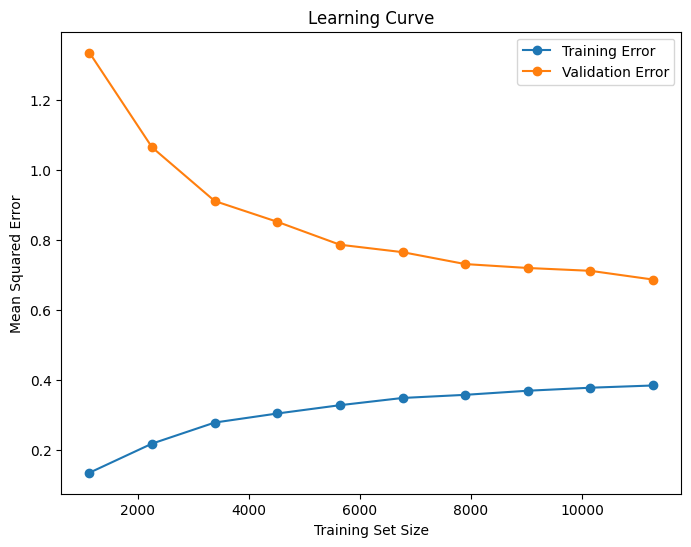

In [12]:
# learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# mean and standard deviation of scores
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.plot(train_sizes, test_scores_mean, label='Validation Error', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

The learning curve demonstrates that the hyperparameter-tuned model is effective, with low training and validation errors. The steady improvement in validation error indicates good generalization, while the remaining gap suggests potential for further optimization. The flattening of both curves highlights that the model has learned most of the underlying patterns in the data.

### Model Evaluation

In [13]:

# Mean Squarred Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R2 score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Adjusted R2 
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print(f"Adjusted R² Score: {r2}")

# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Mean Absolute Percentage Error
y_test = y_test.squeeze()  # Converting DataFrame to Series
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")

# Symmetric MAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
print(f"Symmetric Mean Absolute Percentage Error: {smape}")

Mean Squared Error: 0.7905770963678262
R² Score: 0.9876272678375244
Adjusted R² Score: 0.9876272678375244
Root Mean Squared Error: 0.8891440245358602
Mean Absolute Error: 0.5525075060255984
Mean Absolute Percentage Error: 0.9107351369350696
Symmetric Mean Absolute Percentage Error: 0.9111878531055815


It seems the hyperparameter tuning refined the model's predictive performance, achieving marginally better metrics across the board. These results, combined with consistent improvements in error metrics, highlight the effectiveness of the tuning process in optimizing the model for the dataset. The tuned model represents a strong candidate for deployment.

### Scatter Plot

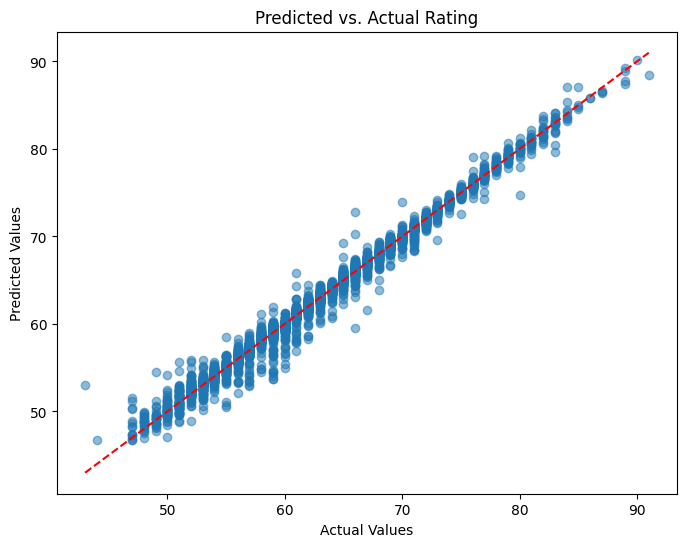

In [14]:
# actual vs. predicted values of "Overall"
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Rating')
plt.show()

The alignment of predictions with actual values is consistent for both lower and higher ranges, indicating improved handling of extreme cases after tuning. Our refined model exhibits better performance for edge cases, particularly for higher actual values where slight deviations were previously observed.


### Residuals Plot

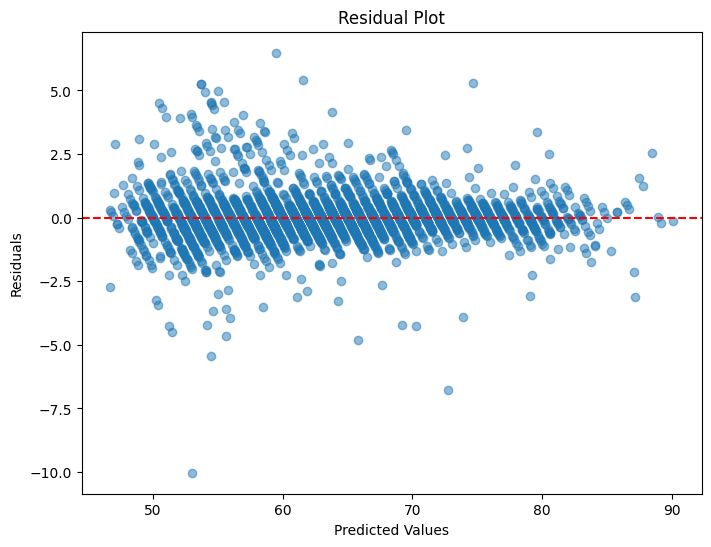

In [15]:
# residuals
residuals = y_test - y_pred

# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Compared to the untuned model, the spread of residuals has reduced, particularly at the higher predicted values, showing that hyperparameter tuning has improved the model's generalization. Outliers (extreme residuals) are less frequent than before tuning, with fewer points deviating far from zero (e.g., beyond -10 or +5). This indicates improved model performance for edge cases.

### Distribution of Residuals 

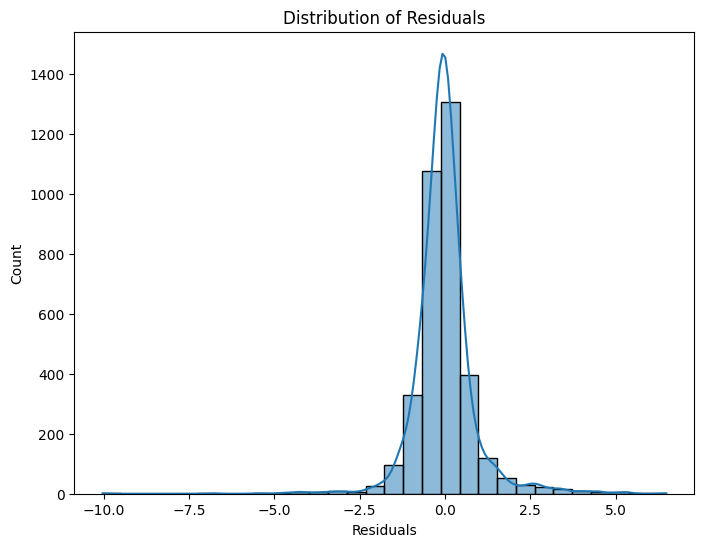

In [16]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

Compared to basic XGBM, the peak around zero is higher and sharper, indicating that the majority of residuals are very small, which is a hallmark of a well-performing model. Overall, the narrow and centered distribution reflects the model's enhanced accuracy after hyperparameter tuning.


### Q-Q Plot for Residuals 

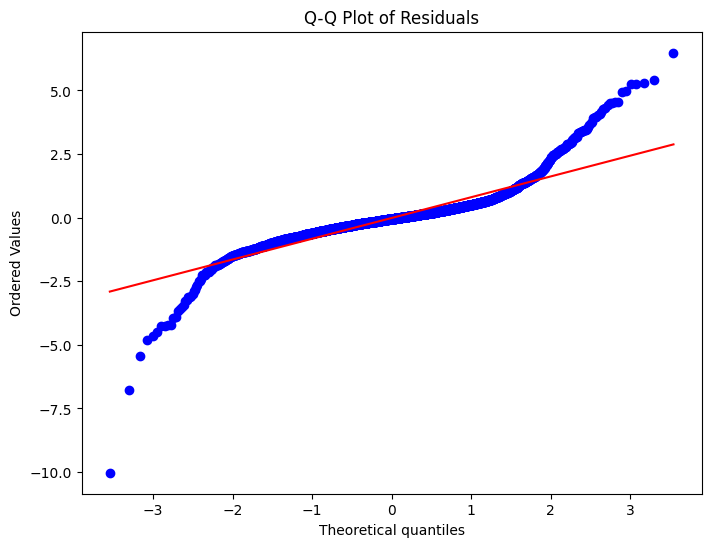

In [17]:
# Q-Q plot for residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

The Q-Q plot after hyperparameter tuning shows significant improvement in the alignment of residuals with a normal distribution. While there are minor deviations at the tails, the central alignment confirms that the tuning process has enhanced the model's performance and robustness for most of the data. These results align with the improved performance metrics observed after tuning.

# Feature Selection

At this stage, we will attempt to investigate where specific features improve our model. We will use Feature Importance to identify the top features:

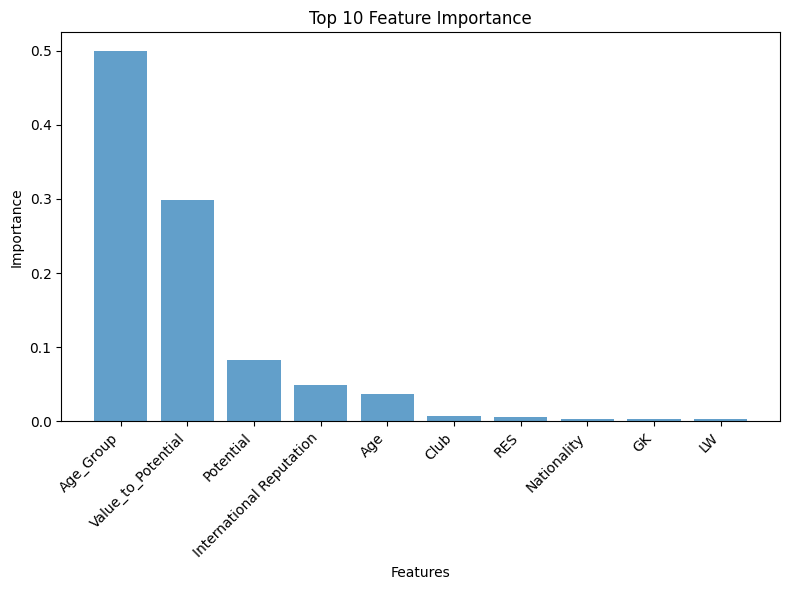

In [26]:
feature_importances = best_model.feature_importances_

# DataFrame for sorting
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_n = 10  # top 5 features to display
importance_df_top = importance_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.bar(importance_df_top['Feature'], importance_df_top['Importance'], alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
selected_features = importance_df['Feature'][:10].tolist()  # Top 5 features
print(f"Selected Features: {selected_features}")

Selected Features: ['Age_Group', 'Value_to_Potential', 'Potential', 'International Reputation', 'Age', 'Club', 'RES', 'Nationality', 'GK', 'LW']


We can now proceed to training our model with these features:


In [28]:
# Select features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train a new XGBRegressor with the best parameters
new_xgb_regressor = XGBRegressor(
    n_estimators=best_model.n_estimators,
    learning_rate=best_model.learning_rate,
    max_depth=best_model.max_depth,
    min_child_weight=best_model.min_child_weight,
    subsample=best_model.subsample,
    colsample_bytree=best_model.colsample_bytree,
    gamma=best_model.gamma,
    reg_alpha=best_model.reg_alpha,
    reg_lambda=best_model.reg_lambda,
    random_state=42
)

# Fit the model with selected features
new_xgb_regressor.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_selected = new_xgb_regressor.predict(X_test_selected)



### Model Evaluation

In [30]:
# Mean Squarred Error
mse = mean_squared_error(y_test, y_pred_selected)
print(f"Mean Squared Error: {mse}")

# R2 score
r2 = r2_score(y_test, y_pred_selected)
print(f"R² Score: {r2}")

# Adjusted R2 
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print(f"Adjusted R² Score: {r2}")

# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_selected)
print(f"Mean Absolute Error: {mae}")

# Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - y_pred_selected) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}")

# Symmetric MAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred_selected)
print(f"Symmetric Mean Absolute Percentage Error: {smape}")

Mean Squared Error: 0.8213008097849716
R² Score: 0.9871464371681213
Adjusted R² Score: 0.9871464371681213
Root Mean Squared Error: 0.906256481237498
Mean Absolute Error: 0.569486427036583
Mean Absolute Percentage Error: 0.9390286246093269
Symmetric Mean Absolute Percentage Error: 0.9395753875728768


The situation is pretty similar as with AdaBoost, i.e. the model does not show much improvement after training with top features.

### Scatter Plot

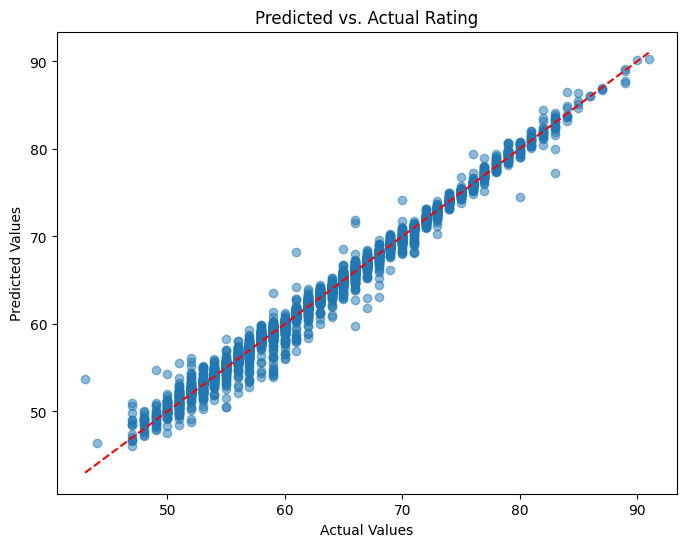

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_selected, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Rating')
plt.show()

### Residual Plot

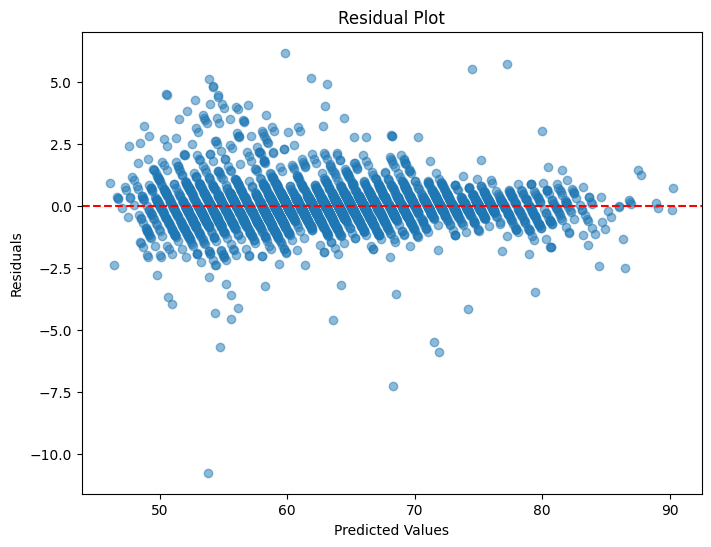

In [32]:
residuals_selected = y_test - y_pred_selected

# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_selected, residuals_selected, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Distribution of Residuals

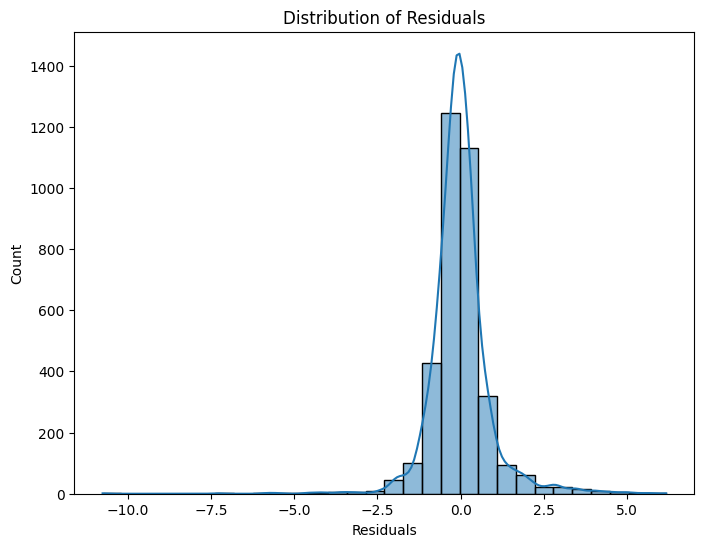

In [33]:
# Histogram of selected residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals_selected, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

### Q-Q Plot for Residuals

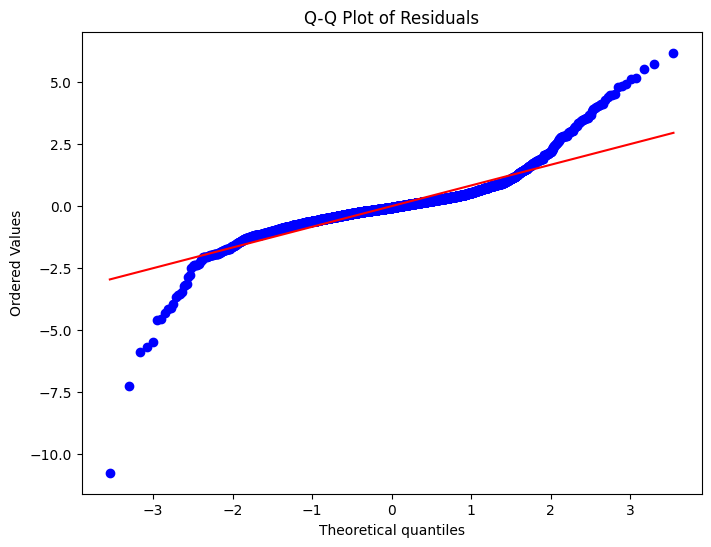

In [34]:
# Q-Q plot for selected residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals_selected, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Summary 

To sum up, hyperparameter tuned XGBoost model demonstrated exceptional performance in predicting the target variable. The fine-tuning process resulted in a model that achieves a strong balance between precision and generalization, as evident from both numerical metrics and visual plots.

The model achieved an R² score of 0.9876, indicating it captures 98.76% of the variance in the target variable. The Mean Squared Error (MSE) of 0.7906 and Root Mean Squared Error (RMSE) of 0.889 reflect highly precise predictions. The Mean Absolute Error (MAE) of 0.553 demonstrates that, on average, predictions deviate by a small margin from actual values. Moreover, the Mean Absolute Percentage Error (MAPE) of 0.911% highlights the model's exceptional accuracy relative to the target variable.

The visualizations further support these findings. The Predicted vs. Actual Values plot illustrates predictions closely following the diagonal line, confirming consistent accuracy across the target range. The Residual Plot shows residuals tightly centered around zero with reduced variability, indicating unbiased predictions. The Residual Distribution Plot highlights a near-normal distribution, validating the model's reliability. The Q-Q Plot reveals improved alignment of residuals with a normal distribution, with only slight deviations observed at the extremes.

While the model performs exceptionally well, a small number of outliers remain, particularly at the tails of the residuals. These minor deviations do not significantly impact the model’s overall reliability. Additionally, the learning curve suggests the model generalizes effectively, with only a slight gap between training and validation errors.